In [1]:
"""
    plot monthly drift data
    create plots of monthly drift data 
"""

import numpy as np
import pandas as pd
import numpy.ma as ma
import matplotlib.pyplot as plt
from glob import glob
from scipy.interpolate import griddata
import os
import pyproj
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

#import helper functions from nkeeney utils.py
import utils as nk

#enable in-line notebook plotting 
%matplotlib inline 

#increase resolution of plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'

# Ignore warnings in the notebook to improve display
# You might want to remove this when debugging/writing new code
import warnings
warnings.filterwarnings('ignore')

In [2]:
#define data path
drift_path = '/Users/nicolekeeney/Desktop/NASA2020/data/drifts/' #path to drift data 

#raise error if data path does not exist
if not os.path.isdir(drift_path):
    raise FileNotFoundError("user-provided path does not exist" + str(drift_path)) 
    
#arctic winter months and corresponding years
winter_18_19 = [['Nov','2018'],['Dec','2018'],['Jan','2019'],['Feb','2019'],['Mar','2019'],['Apr','2019']]
winter_19_20 = [['Nov','2019'],['Dec','2019'],['Jan','2020'],['Feb','2020'],['Mar','2020'],['Apr','2020']]

In [4]:
def get_uv_from_xy(xdrift, ydrift, lon):
    # convert the drift vectors to zonal/meridional (luckily this dosn't need the original map projection, at least i don't think it does)
    alpha = lon*np.pi/180. #convert longitudes to radians 
    uvelT = ydrift*np.sin(alpha) + xdrift*np.cos(alpha)
    vvelT = ydrift*np.cos(alpha) - xdrift*np.sin(alpha) 
    return uvelT, vvelT

In [5]:
#combine nc weekly files into a single xarray dataset
files = [xr.open_dataset(drift_path+f) for f in os.listdir(drift_path) if os.path.isfile(drift_path+ f) and f.endswith('.nc')]
weekly_drifts = xr.concat(files, dim = 'time')
weekly_drifts.attrs['nkeeney comment'] = 'drift dataset from 1978-2018 was combined with quicklook drift dataset from 2019-present, maintaining attitributes of the 1978-2018 dataset'

#get transformed u,v variables and add to dataset
uvelT, vvelT = get_uv_from_xy(weekly_drifts.u, weekly_drifts.v, weekly_drifts.longitude)
weekly_drifts = weekly_drifts.assign(uT = uvelT, vT = vvelT)
weekly_drifts.uT.attrs = {'comment':'along-x component of the ice motion (u variable) converted to zonal/meridional'}
weekly_drifts.vT.attrs = {'comment':'along-y component of the ice motion (v variable) converted to zonal/meridional'}

#get date range for both winters
weekly_drifts['time'] = weekly_drifts.indexes['time'].to_datetimeindex().strftime("%Y-%m-%dT00:00:00.000000000").astype('datetime64[ns]') #convert time index to datetime
weekly_drifts.time.attrs = {'standard_name':'time', 'nkeeney comment':'time in datetime format (converted from original datetime julian format)'}
monthly_drifts = weekly_drifts.resample(time='MS', keep_attrs = True).mean() #get mean monthly data

#get data for each winter season
date_range_1 = nk.get_date_range(winter_18_19)
date_range_2 = nk.get_date_range(winter_19_20)
monthly_drifts_1 = monthly_drifts.sel(time = date_range_1)
monthly_drifts_2 = monthly_drifts.sel(time = date_range_2)

In [68]:
def plot_monthly_drifts(data, lons, lats, uvelT, vvelT, proj = ccrs.NorthPolarStereo(central_longitude=-45), 
                        minval = 0, maxval = 15, vector_val = 10, res = 4, scale_vec = 100, 
                        var_str = 'NSIDC ice drift', units_vec = 'cm/s'): 
    
    fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(7.5, 5.8), subplot_kw={'projection': proj})
    winter_str = 'Winter ' + data.time.values[0].astype('str')[2:4] + '-' + data.time.values[-1].astype('str')[2:4]
    fig.suptitle(winter_str + ': ' + var_str + ' (' + units_vec + ')', y=1.05, fontsize = 16)

    for i in range(6):
        ax = axs.flatten()[i]
        plt.sca(ax)
        mon_name = nk.monNumToName(int(data.time[i].values.astype('str')[5:7]))
        yr = data.time[i].values.astype('str')[:4]
        ax.set_title(mon_name + ' ' + yr)
        
        #plot vector magnitudes 
        var_mag = np.sqrt(uvelT[i]**2 + vvelT[i]**2)
        im = ax.pcolormesh(lons[i], lats[i], var_mag, vmin=minval, vmax=maxval, transform=ccrs.PlateCarree(), zorder=2, cmap = 'GnBu')
        
        # Following https://github.com/SciTools/cartopy/issues/1179 we need to rescale the 
        u_src_crs = uvelT[i] / np.cos(lats[i] / 180 * np.pi)
        v_src_crs = vvelT[i]
        magnitude = np.sqrt(uvelT[i]**2 + vvelT[i]**2)
        magn_src_crs = np.sqrt(u_src_crs**2 + v_src_crs**2)
        var_u_scaled = u_src_crs * magnitude / magn_src_crs
        var_v_scaled = v_src_crs * magnitude / magn_src_crs
        
        Q = ax.quiver(lons[i][::res, ::res], lats[i][::res, ::res], var_u_scaled[::res, ::res], var_v_scaled[::res, ::res], transform=ccrs.PlateCarree(), units='inches',scale=scale_vec, zorder=5)
        ax.set_extent([-179, 179, 50, 90], ccrs.PlateCarree())
        ax.coastlines(linewidth=0.25, color = 'black', zorder = 7)
        ax.add_feature(cfeature.LAND, color='0.95', zorder = 5)
        ax.add_feature(cfeature.LAKES, color='grey', zorder = 5)
        ax.gridlines(draw_labels=False,linewidth=0.25, color='gray', alpha=0.5, linestyle='--', zorder = 10)
        cax = fig.add_axes([0.3, 0.02, 0.35, 0.03])
        cb = fig.colorbar(im,cax=cax,extend='both',orientation = 'horizontal', fraction=0.046, pad=0.05, shrink = 0.7)
        cb.set_label(var_str + ' (' + units_vec + ')', size=8)
        cb.set_ticks(np.arange(minval,maxval+5,5))
        ax.set_title(mon_name + ' ' + yr)
        qk = plt.quiverkey(Q, 3389969, 3389969, vector_val, str(vector_val)+' '+units_vec, coordinates='data', zorder = 11)   
        plt.tight_layout()
    plt.savefig(fig_path + 'ice drift plot ' + winter_str + '.png', dpi=300, bbox_inches = 'tight')
    plt.show()

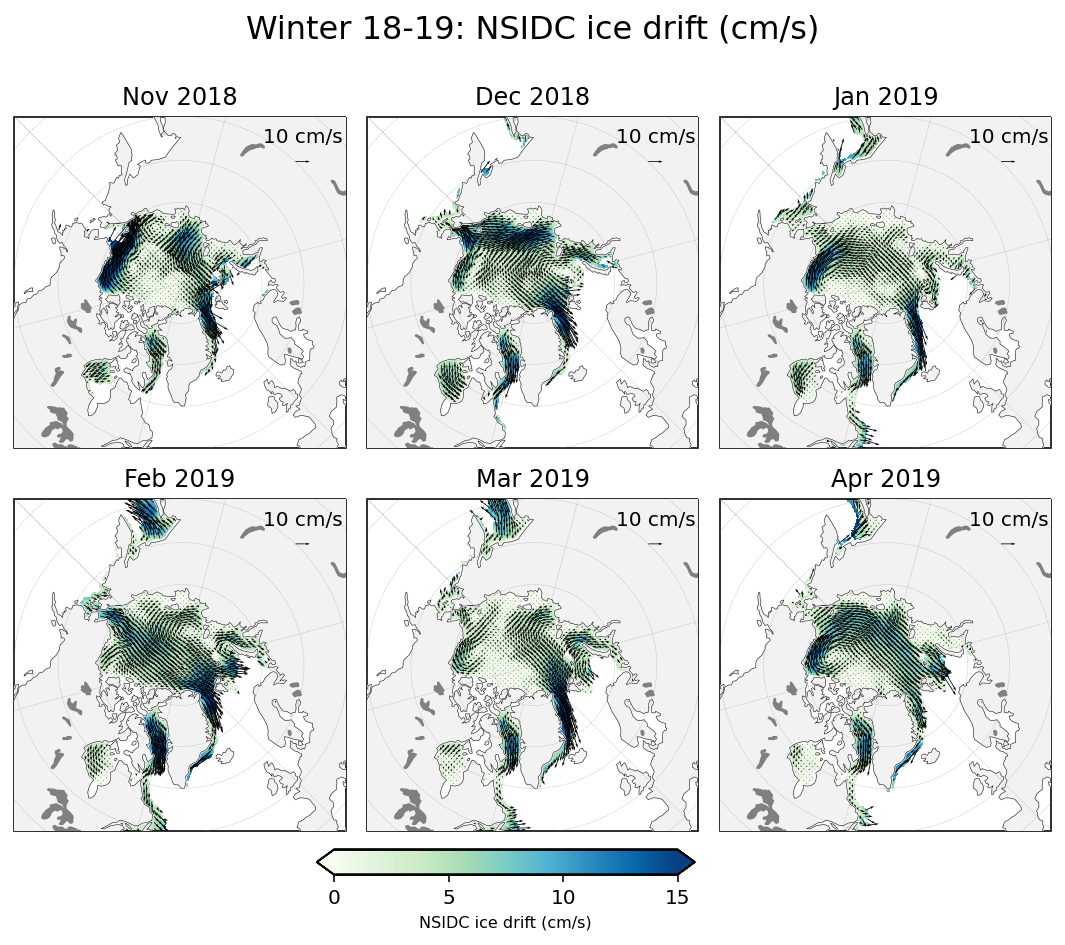

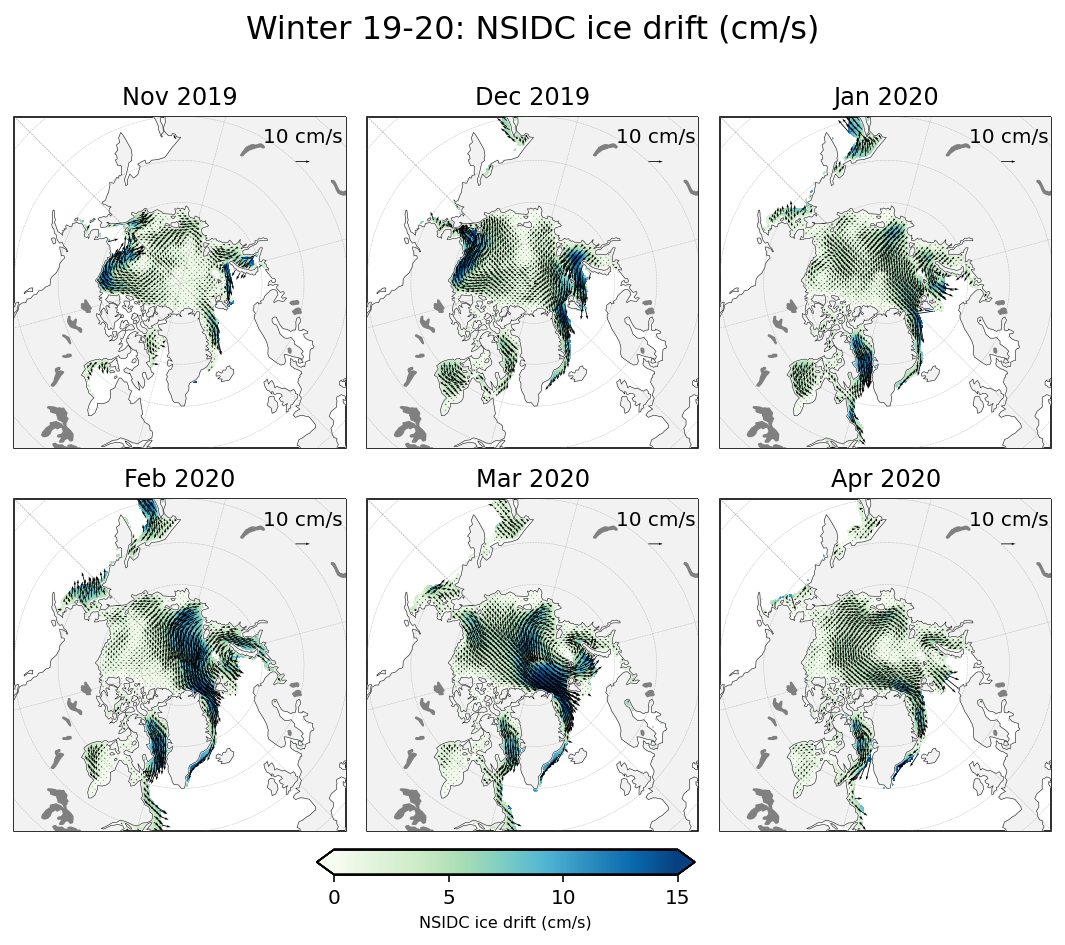

In [69]:
data = monthly_drifts_1
lons = data.longitude.values
lats = data.latitude.values
uvelT = data.uT.values
vvelT = data.vT.values
plot_monthly_drifts(data,lons, lats, uvelT, vvelT)

data = monthly_drifts_2
lons = data.longitude.values
lats = data.latitude.values
uvelT = data.uT.values
vvelT = data.vT.values
plot_monthly_drifts(data,lons, lats, uvelT, vvelT)

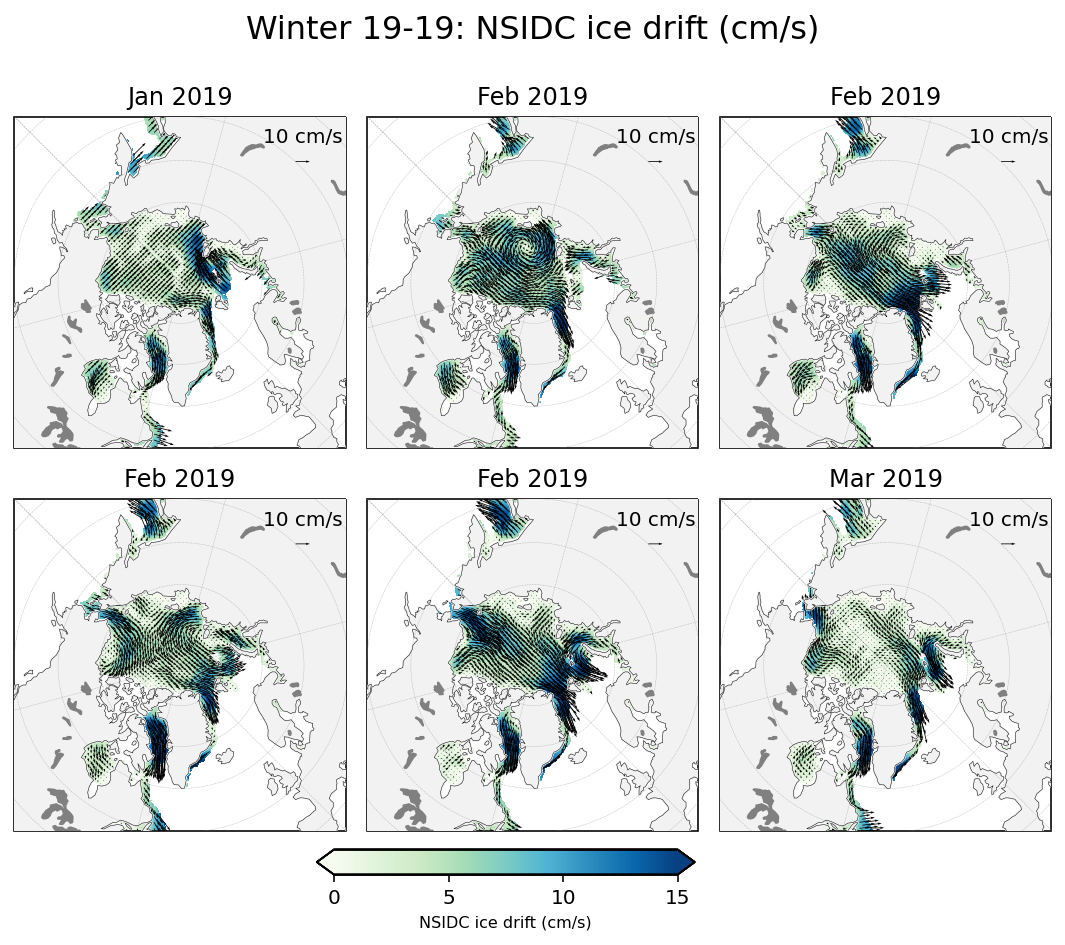

In [73]:
data = weekly_drifts.isel(time = np.arange(56,62,1))
lons = data.longitude.values
lats = data.latitude.values
uvelT = data.uT.values
vvelT = data.vT.values
plot_monthly_drifts(data,lons, lats, uvelT, vvelT)

2020-02-26T00:00:00.000000000


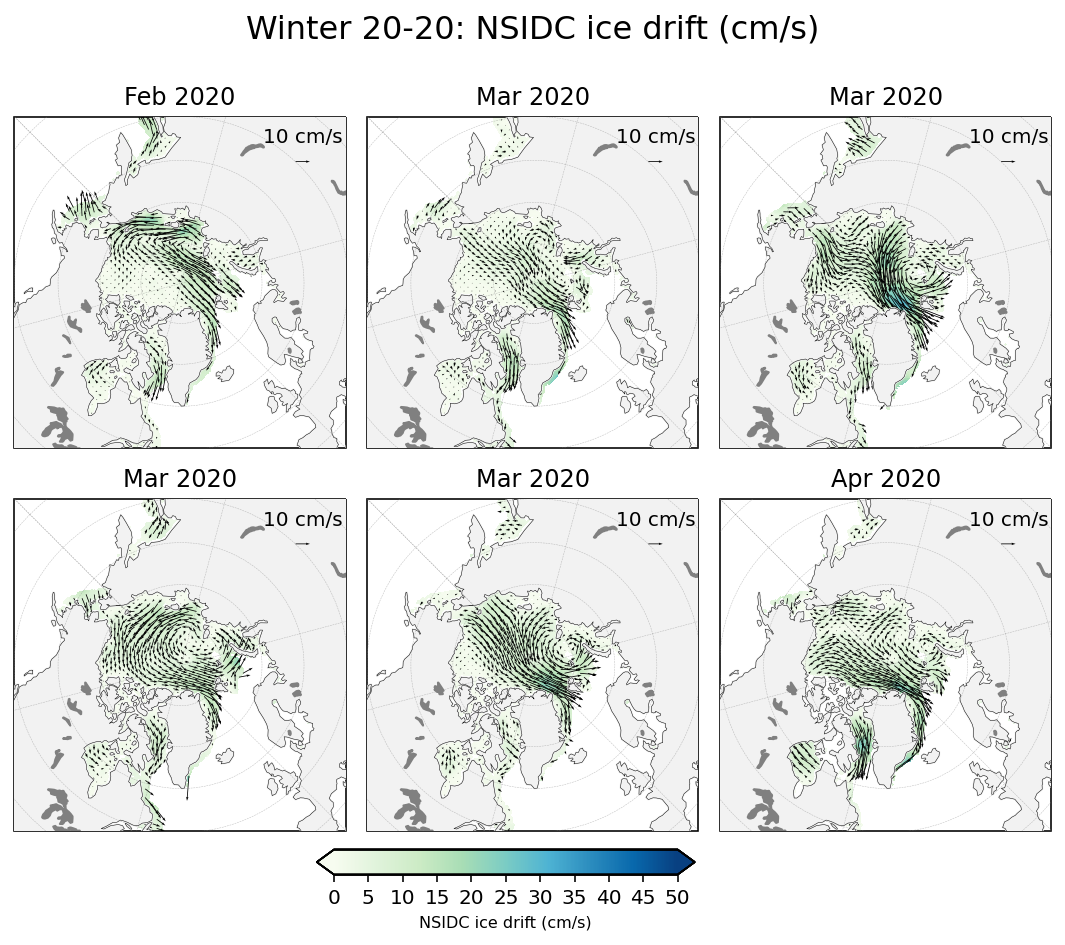

In [81]:
data = weekly_drifts.isel(time = np.arange(-14,-8,1))
print(data.time[0].values)
lons = data.longitude.values
lats = data.latitude.values
uvelT = data.uT.values
vvelT = data.vT.values
plot_monthly_drifts(data, lons, lats, uvelT, vvelT, res = 6, maxval = 50)

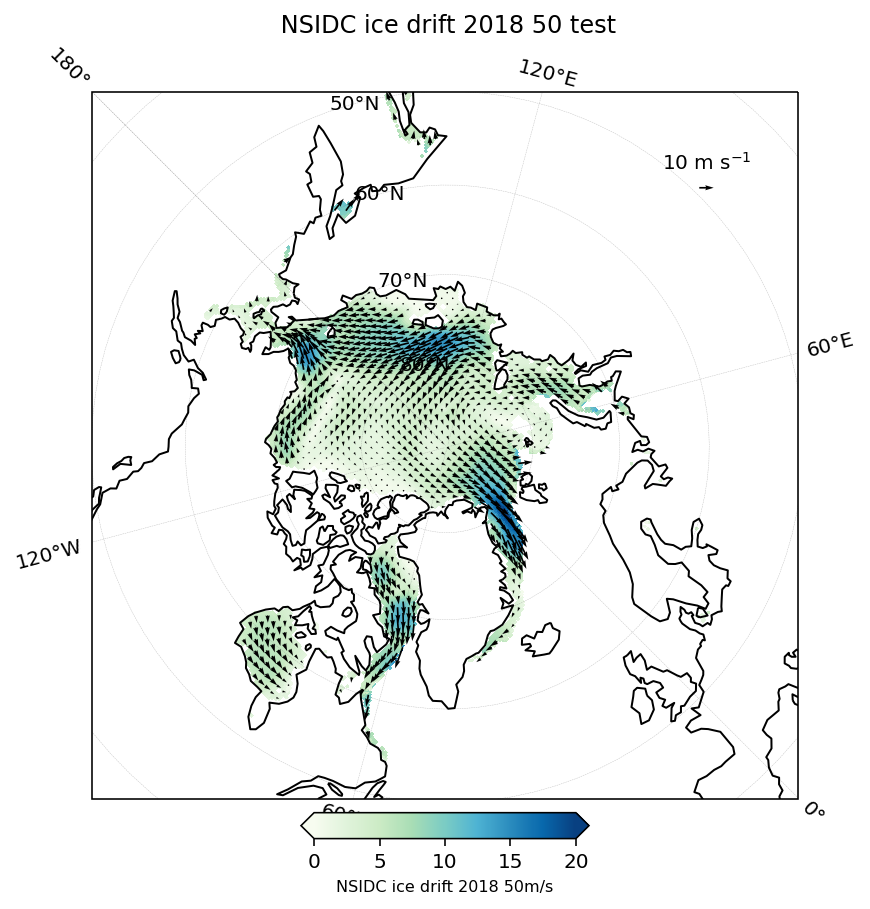

In [16]:
week = 50
data = monthly_drifts_1.isel(time = 1)
lons = data.longitude.values
lats = data.latitude.values
uvelT = data.uT.values
vvelT = data.vT.values
vect_mag = np.sqrt((uvelT**2) + (vvelT**2))#magnitude of the u and v vectors
plot_drift_cartopy_uv(lons, lats, uvelT, vvelT, vect_mag,  out=fig_path+'test_raw_2018 '+str(week), units_lab='m/s', units_vec=r'm s$^{-1}$',
	minval=0, maxval=20, vector_val=10, res=4, scale_vec=100, date_string='test', month_string='', varStr='NSIDC ice drift 2018 '+str(week),cbar_type='max', cmap_1=plt.cm.viridis)

In [39]:
def plot_drifts(data, fig_path, minval = 0, maxval = 15, res = 5, vector_val = 10, units_vec = 'cm/s', var_str = 'mean monthly NSIDC ice drift', proj = ccrs.NorthPolarStereo(central_longitude=-45)):
    fig,axs = plt.subplots(nrows=2, ncols=3, figsize=(7.5, 5.8), subplot_kw={'projection': proj})
    plt.subplots_adjust(bottom=0.12, left=0.01, top = 0.95, right=0.99, wspace=0.02, hspace=0.03)
    winter_str = 'Winter ' + data.time.values[0].astype('str')[2:4] + '-' + data.time.values[-1].astype('str')[2:4]
    fig.suptitle(winter_str + ': ' + var_str + ' (' + units_vec + ')', y=1.05, fontsize = 16)

    for i in range(6):
        ax = axs.flatten()[i]
        plt.sca(ax)

        curr_data = data.isel(time = i) #select monthly data by index
        mon_name = nk.monNumToName(int(curr_data.time.values.astype('str')[5:7]))
        yr = curr_data.time.values.astype('str')[:4]
        lons = curr_data.longitude.values
        lats = curr_data.latitude.values
        uvelT, vvelT = get_uv_from_xy(curr_data.u.values, curr_data.v.values, lons)
        vect_mag = np.sqrt((uvelT**2) + (vvelT**2))#magnitude of the u and v vectors

        #colormesh plot of vector magnitudes
        im = ax.pcolormesh(lons, lats, vect_mag, vmin=minval, vmax=maxval, transform=ccrs.PlateCarree(), zorder=2, cmap = 'GnBu')

        #rescale vectors following https://github.com/SciTools/cartopy/issues/1179  
        u_src_crs = uvelT / np.cos(lats/(180*np.pi))
        v_src_crs = vvelT
        magnitude = np.sqrt((uvelT**2) + (vvelT**2))
        magn_src_crs = np.sqrt((u_src_crs**2) + (v_src_crs**2))
        var_u_scaled = u_src_crs * magnitude / magn_src_crs
        var_v_scaled = v_src_crs * magnitude / magn_src_crs

        #plot vectors 
        Q = ax.quiver(lons[::res, ::res], lats[::res, ::res], var_u_scaled[::res, ::res], var_v_scaled[::res, ::res], transform=ccrs.PlateCarree(), units='inches', scale = 100, zorder=5)
        ax.set_extent([-179, 179, 50, 90], ccrs.PlateCarree())
        ax.coastlines(linewidth=0.25, color = 'black', zorder = 7)
        ax.add_feature(cfeature.LAND, color='0.95', zorder = 5)
        ax.add_feature(cfeature.LAKES, color='grey', zorder = 5)
        ax.gridlines(draw_labels=False,linewidth=0.25, color='gray', alpha=0.5, linestyle='--', zorder = 10)
        cax = fig.add_axes([0.3, 0.02, 0.35, 0.03])
        cb=fig.colorbar(im,cax=cax,extend='both',orientation = 'horizontal', fraction=0.046, pad=0.05, shrink = 0.7)
        cb.set_label(var_str + ' (' + units_vec + ')', size=8)
        cb.set_ticks(np.arange(minval,maxval+5,5))
        ax.set_title(mon_name + ' ' + yr)
        qk = plt.quiverkey(Q, 3389969, 3389969, vector_val, str(vector_val)+' '+units_vec, coordinates='data', zorder = 11)   
        plt.tight_layout() 
        
    plt.savefig(fig_path + 'ice drift plot ' + winter_str + '.png', dpi=300, bbox_inches = 'tight')
    plt.show()

In [ ]:
data = weekly_drifts.isel(time = np.arange(44,50,1))

plot_drifts(data, fig_path)
#plot_drifts(data, fig_path)

In [6]:
def plot_drift_cartopy_uv(lons, lats, var_u, var_v, var_mag, proj=ccrs.NorthPolarStereo(central_longitude=-45), shading='flat', out='./figure', units_lab='units', units_vec='', varStr='',
 minval=1., maxval=1., date_string='year', month_string='months', extra='', res=2, scale_vec=1, vector_val=1, cbar_type='both', cmap_1=plt.cm.viridis, norm=0):
	#proj = ccrs.epsg(epsg_string)
	#proj = ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90, false_easting=0.0, false_northing=0.0, globe=None)
	# The projection keyword determines how the plot will look
	fig=plt.figure(figsize=(5, 6))
	ax = plt.axes(projection = proj)
	#ax.imshow(data, transform=ccrs.PlateCarree(), zorder=2)
	cs = ax.pcolormesh(lons, lats, var_mag, vmin=minval, vmax=maxval, transform=ccrs.PlateCarree(), zorder=2, cmap = 'GnBu')
	# Following https://github.com/SciTools/cartopy/issues/1179 we need to rescale the 
	u_src_crs = var_u / np.cos(lats / 180 * np.pi)
	v_src_crs = var_v
	magnitude = np.sqrt(var_u**2 + var_v**2)
	magn_src_crs = np.sqrt(u_src_crs**2 + v_src_crs**2)
	var_u_scaled = u_src_crs * magnitude / magn_src_crs
	var_v_scaled = v_src_crs * magnitude / magn_src_crs
	Q = ax.quiver(lons[::res, ::res], lats[::res, ::res], var_u_scaled[::res, ::res], var_v_scaled[::res, ::res], transform=ccrs.PlateCarree(), units='inches',scale=scale_vec, zorder=5)
	ax.coastlines(zorder=3)
	ax.gridlines(draw_labels=True,
              linewidth=0.22, color='gray', alpha=0.5, linestyle='--')
	#ax.imshow(data, transform=ccrs.PlateCarree(), zorder=2)
	# for some reason this extent can freak out if you set 180 to 180
	ax.set_extent([-179, 179, 50, 90], ccrs.PlateCarree())
	cax = fig.add_axes([0.3, 0.08, 0.4, 0.03])
	#cax,kw = matplotlib.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
	cb=fig.colorbar(cs,cax=cax,extend='both',orientation = 'horizontal', fraction=0.046, pad=0.05, shrink = 0.7)
	cb.set_label(varStr+units_lab,size=8)
	ax.set_title(' '+varStr+' '+date_string+month_string+extra)
	qk = plt.quiverkey(Q, 3389969, 3389969, vector_val, str(vector_val)+' '+units_vec, coordinates='data', zorder = 11)   
	plt.tight_layout()
	#print 'Saving..'    
	plt.subplots_adjust(bottom=0.12, left=0.01, top = 0.95, right=0.99, wspace=0.02, hspace=0.03)
	plt.savefig(out+'.png', dpi=200)
	plt.show()
	plt.close(fig)

In [ ]:
f